# Imports

In [13]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

#device = 0
#torch.cuda.set_device(device)

In [14]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../fastai/') #fastai version 1.0

from fastai.vision import *

import pandas as pd
import numpy as np
import os
import torch
import torchvision
from torchvision.models import *
from torchsummary import summary
from pathlib import Path
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_curve, auc, roc_auc_score

PATH = Path('/home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection')
TRAIN_NAME = 'train'
TRAIN = PATH/TRAIN_NAME
CSV_NAME = 'train_labels.csv'
LABELS = PATH/CSV_NAME
TEST_NAME = 'test'
TEST = PATH/TEST_NAME
SAMPLE = PATH/'sample_submission.csv'
SUBMISSIONS = PATH/'submissions'
SUBMISSIONS.mkdir(exist_ok=True)

nw = 8   #number of workers for data loader
torch.backends.cudnn.benchmark=True
np.random.seed(42)

def batch_stats(self, funcs:Collection[Callable]=None)->Tensor:
        "Grab a batch of data and call reduction function `func` per channel"
        funcs = ifnone(funcs, [torch.mean,torch.std])
        x = self.one_batch(ds_type=DatasetType.Train, denorm=False)[0].cpu()
        return [func(channel_view(x), 1) for func in funcs]
    
    
vision.data.ImageDataBunch.batch_stats = batch_stats

sz = 96
bs = 128
dropout = 0.5

# Data 

In [15]:
get_transforms(do_flip=True, flip_vert=True, max_rotate=.0, max_zoom=.1,
                      max_lighting=0.05, max_warp=0.)

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.475, 0.525)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.95, 1.0526315789473684)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])

In [16]:
tfms = ([crop(size=sz),
        RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True),
        RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.475, 0.525)}, p=0.75, resolved={}, do_run=True, is_random=True),
        RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.95, 1.0526315789473684)}, p=0.75, resolved={}, do_run=True, is_random=True)],
      #RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
      #RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
      #RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
      #RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)],
     [crop(size=sz)])

In [17]:
data = (ImageItemList.from_csv(path=PATH, csv_name=CSV_NAME, folder=TRAIN_NAME, suffix='.tif')
#.random_split_by_pct(0.01)
.no_split()
.label_from_df()
.add_test_folder(test_folder=TEST_NAME, label=None)
.transform(tfms)
.databunch(bs=bs, num_workers=nw)
#.normalize(imagenet_stats))
.normalize())

In [18]:
data

ImageDataBunch;

Train: LabelList (220025 items)
x: ImageItemList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,0
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection;

Valid: LabelList (0 items)
x: ImageItemList

y: CategoryList

Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection;

Test: LabelList (57458 items)
x: ImageItemList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection

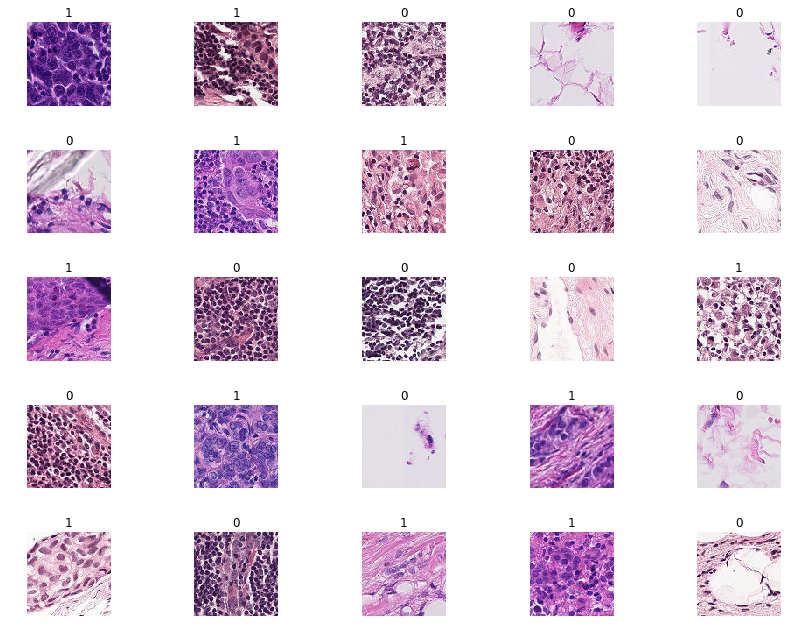

In [8]:
data.show_batch(rows=5, figsize=(12,9))

# Metrics 

In [19]:
def roc_curve_custom(y_pred:torch.Tensor, y_true:torch.Tensor):
    probs = y_pred[:,-1]
    fpr, tpr, thresholds = roc_curve(y_true, probs, pos_label=1)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

def auc_score_1(y_pred:torch.Tensor, y_true:torch.Tensor):
    fpr, tpr, thresholds, roc_auc = roc_curve_custom(y_pred, y_true)
    return torch.as_tensor(roc_auc)

def auc_score_2(y_pred,y_true,tens=True):
    score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    if tens:
        score=tensor(score)
    else:
        score=score
    return score

# Learner

## Create

In [20]:
arch = torchvision.models.vgg16

In [21]:
learner = create_cnn(data=data, 
                     arch=arch, 
                     metrics=[accuracy, auc_score_1, auc_score_2], 
                     ps=dropout)

## Train

### Multiple cycles

In [5]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


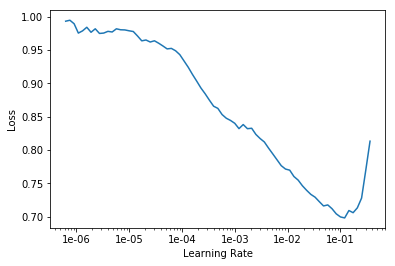

In [6]:
learner.recorder.plot()

In [11]:
lr = 1e-2
cycle_len_head=5

In [ ]:
learner.fit_one_cycle(cycle_len_head, slice(lr))

In [ ]:
learner.recorder.plot_lr(show_moms=True)

In [ ]:
learner.save(f'{arch.__name__}-head')

In [6]:
learner.load('resnet50-head')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (176020 items)
[Category 0, Category 1, Category 0, Category 0, Category 0]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection
x: ImageItemList (176020 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection;

Valid: LabelList
y: CategoryList (44005 items)
[Category 0, Category 1, Category 0, Category 0, Category 1]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection
x: ImageItemList (44005 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection;

Test: LabelList
y: EmptyLabelList (57458 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (57458 items)
[Image

In [7]:
learner.unfreeze()

In [8]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


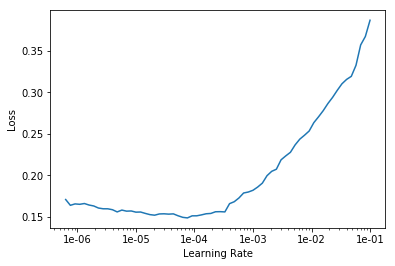

In [9]:
learner.recorder.plot()

In [20]:
lr2 = 1e-5

In [12]:
learner.fit_one_cycle(cyc_len=1, max_lr=slice(lr2, lr/5))

epoch,train_loss,valid_loss,accuracy
1,0.149396,0.119367,0.957096


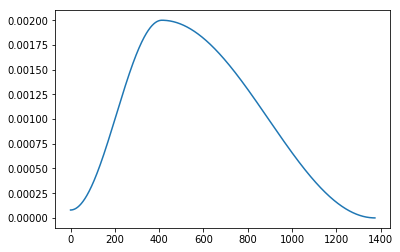

In [13]:
learner.recorder.plot_lr()

In [14]:
learner.save(f'{arch.__name__}-complete-1')

epoch,train_loss,valid_loss,accuracy
1,0.151710,0.132558,0.950710
2,0.117313,0.103587,0.963004


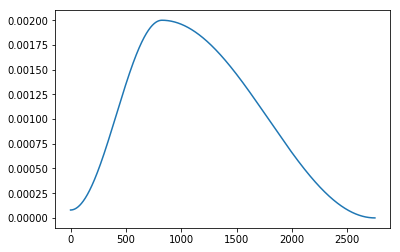

In [15]:
learner.fit_one_cycle(cyc_len=2, max_lr=slice(lr2, lr/5))
learner.recorder.plot_lr()
learner.save(f'{arch.__name__}-complete-2')

epoch,train_loss,valid_loss,accuracy
1,0.139794,0.119252,0.957255
2,0.125170,0.115113,0.958164
3,0.107394,0.092442,0.967322
4,0.090649,0.090092,0.968890


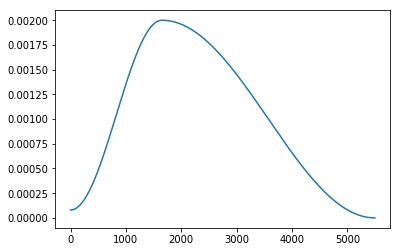

In [17]:
learner.fit_one_cycle(cyc_len=4, max_lr=slice(lr2, lr/5))
learner.recorder.plot_lr()
learner.save(f'{arch.__name__}-complete-3')

epoch,train_loss,valid_loss,accuracy
1,0.108450,0.097394,0.965458
2,0.116108,0.106072,0.963095
3,0.112058,0.100635,0.964186
4,0.086022,0.084450,0.970912
5,0.082883,0.081713,0.970912
6,0.069958,0.077234,0.972321


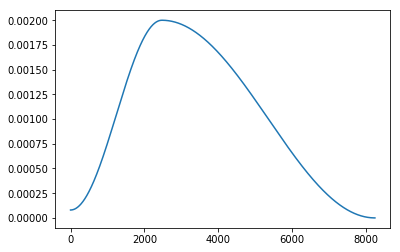

In [19]:
learner.fit_one_cycle(cyc_len=6, max_lr=slice(lr2, lr/5))
learner.recorder.plot_lr()
learner.save(f'{arch.__name__}-complete-4')

epoch,train_loss,valid_loss,accuracy
1,0.072122,0.080197,0.971321
2,0.076660,0.087566,0.972162
3,0.077762,0.078887,0.972776
4,0.070409,0.076694,0.973139
5,0.070783,0.073485,0.974957
6,0.068790,0.072949,0.974435
7,0.067622,0.073835,0.974094
8,0.057429,0.073932,0.974026


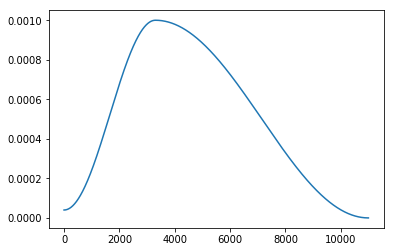

In [21]:
learner.fit_one_cycle(cyc_len=8, max_lr=slice(lr2/10, lr/10))
learner.recorder.plot_lr()
learner.save(f'{arch.__name__}-complete-5')

epoch,train_loss,valid_loss,accuracy
1,0.061565,0.073237,0.974798
2,0.058475,0.073333,0.974253
3,0.058036,0.073755,0.974412
4,0.064055,0.073075,0.974707
5,0.059303,0.071938,0.975116
6,0.061731,0.072562,0.975253
7,0.061684,0.072375,0.974912
8,0.056020,0.073141,0.974412


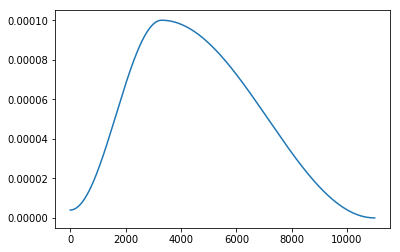

In [22]:
learner.fit_one_cycle(cyc_len=8, max_lr=slice(lr2/100, lr/100))
learner.recorder.plot_lr()
learner.save(f'{arch.__name__}-complete-6')

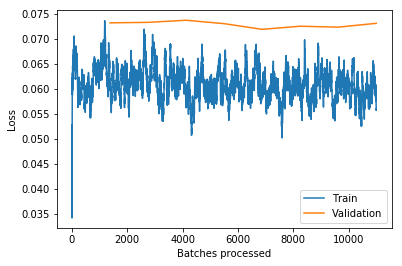

In [23]:
learner.recorder.plot_losses()

### One long cycle

In [22]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.00E-03


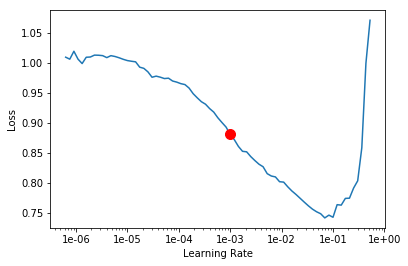

In [24]:
learner.recorder.plot()

In [25]:
lr = 3e-2

In [26]:
learner.fit_one_cycle(cyc_len=1, max_lr=lr)

ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

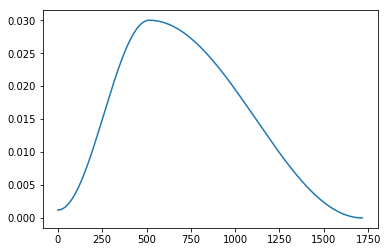

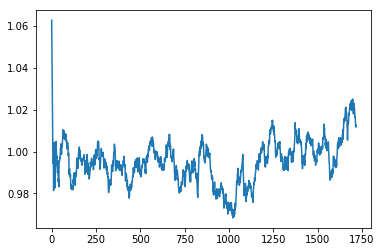

In [28]:
learner.recorder.plot_lr()
learner.recorder.plot_losses()

In [29]:
nameHead = f'{arch.__name__}-cropped_{sz}_ps{dropout}-100%_dataset-head'
learner.save(nameHead)

In [38]:
#learner.load(nameHead)

In [39]:
learner.unfreeze()

In [40]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-07


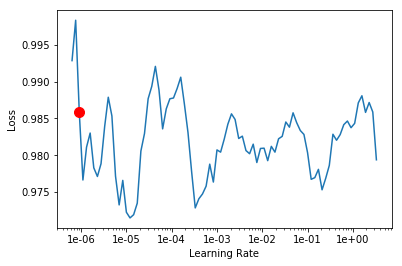

In [41]:
learner.recorder.plot()

In [42]:
lr2 = 1e-4
lr3 = 1e-3

In [43]:
learner.fit_one_cycle(cyc_len=20, max_lr=slice(lr2, lr3))

In [44]:
nameComplete = f'{arch.__name__}-cropped_{sz}_ps{dropout}-100%_dataset-complete'
learner.save(nameComplete)

# Interpreter

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(16)

# Validation Set

## Prediction

In [28]:
preds,y=learner.TTA(ds_type=DatasetType.Valid, scale=1)

## AUC Score

In [29]:
pred_score_tta_1=auc_score_1(preds,y)
pred_score_tta_1

tensor(0.9981)

In [30]:
pred_score_tta_2=auc_score_2(preds,y)
pred_score_tta_2

tensor(0.9981)

## ROC curve and AUC on validation set

In [31]:
fpr, tpr, thresholds, roc_auc = roc_curve_custom(preds, y)

In [32]:
roc_auc

0.9980848414551811

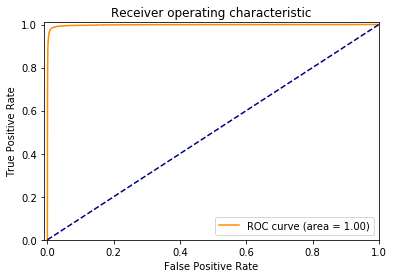

In [33]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

## Finding threshold on validation set

In [34]:
import scipy.optimize as opt
from sklearn.model_selection import train_test_split

In [35]:
pred = preds[:, 1]

In [36]:
pred_tensor = pred
y_tensor = y

pred = np.asarray(pred)
y = np.asarray(y)

In [37]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.,d=25.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = np.zeros(1)
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [38]:
import sklearn
th = fit_val(pred, y)
print('Thresholds: ',th)
print('F1 macro: ', sklearn.metrics.f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.0): ', sklearn.metrics.f1_score(y, pred>0.0, average='macro'))
print('F1 micro: ', sklearn.metrics.f1_score(y, pred>th, average='micro'))

Thresholds:  [0.498545]
F1 macro:  0.9849769628141016
F1 macro (th = 0.0):  0.28832500444746334
F1 micro:  0.9855243722304283


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
from sklearn.model_selection import train_test_split
th, score, cv = 0,0,10
for i in range(cv):
    xt,xv,yt,yv = train_test_split(pred,y,test_size=0.5,random_state=i)
    th_i = fit_val(xt,yt)
    th += th_i
    score +=  sklearn.metrics.f1_score(yv, xv>th_i, average='macro')
th/=cv
score/=cv
print('Thresholds: ',th)
print('F1 macro avr:',score)
print('F1 macro: ', sklearn.metrics.f1_score(y, pred>th, average='macro'))
print('F1 micro: ', sklearn.metrics.f1_score(y, pred>th, average='micro'))


print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > 0.5).mean(axis=0))

Thresholds:  [0.481899]
F1 macro avr: 0.9848190787747916
F1 macro:  0.9850265550264219
F1 micro:  0.9855698216111806
Fractions:  0.4043858652425861
Fractions (true):  0.40513578002499717


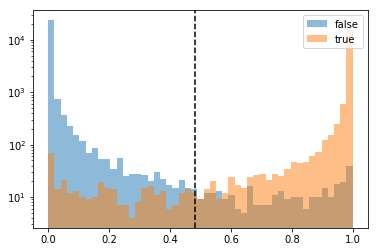

In [40]:
f1 =  sklearn.metrics.f1_score(y, pred>th, average=None)
bins = np.linspace(pred[:].min(), pred[:].max(), 50)
plt.hist(pred[y[:] == 0][:], bins, alpha=0.5, log=True, label='false')
plt.hist(pred[y[:] == 1][:], bins, alpha=0.5, log=True, label='true')
plt.legend(loc='upper right')
plt.axvline(x=th[0], color='k', linestyle='--')
plt.show()

# Test Set

In [45]:
n = np.load('n.npy')

In [46]:
n

array(63)

## Single Model

In [47]:
preds_test_tta,y_test_tta=learner.TTA(ds_type=DatasetType.Test, scale=1)
preds_test = preds_test_tta
name = f'{n}-{arch.__name__}_sz{sz}_bs{bs}_ps{dropout}-100%_dataset.csv'

## Ensembling

In [64]:
arch_list = [densenet169, vgg16]

In [65]:
dict_arch_savedModel = {densenet169:'densenet169-cropped_96-complete', 
                        vgg16:'vgg16-cropped_96-complete'}

In [94]:
name = f'{n}-{str(list(dict_arch_savedModel.values()))}_sz{sz}_bs{bs}_ensembled.csv'; name

"['densenet169-cropped_96-complete', 'vgg16-cropped_96-complete']_sz96_bs128_ensembled.csv"

In [68]:
predsList = []
for arch in arch_list:
    learner = create_cnn(data=data, arch=arch)
    learner.load(dict_arch_savedModel[arch])
    preds_test_tta,y_test_tta=learner.TTA(ds_type=DatasetType.Test, scale=1)
    predsList.append(preds_test_tta)

In [84]:
preds_ensembled = predsList[0]
for n, _ in enumerate(predsList):
    if n == 0:
        continue
    else:
        preds_ensembled = preds_ensembled + predsList[n]
preds_ensembled = preds_ensembled/len(predsList)

In [85]:
preds_test = preds_ensembled

# Submission

In [48]:
clean_fname=np.vectorize(lambda fname: str(fname).split('/')[-1].split('.')[0])
fnames_cleaned=clean_fname(data.test_ds.items).astype(str)

In [49]:
probs = np.array(preds_test[:,-1])

#pred_labels = np.where(probs > th, 1, 0)
df = pd.DataFrame({'id':[fname for fname in fnames_cleaned], 'label':probs})
df.to_csv(SUBMISSIONS/name, header=True, index=False)
n = n+1
np.save('n', n)
n

64

## obsolete

In [62]:
clean_fname=np.vectorize(lambda fname: str(fname).split('/')[-1].split('.')[0])
fnames_cleaned=clean_fname(data.test_ds.items).astype(str)

sub=pd.read_csv(SAMPLE).set_index('id')
sub.loc[fnames_cleaned,'label']=(to_np(preds_test_tta[:,1]) > th).astype(np.int)
name = f'{n}-{arch.__name__}_sz{sz}_bs{bs}_th{th}.csv'
sub.to_csv(SUBMISSIONS/name)